Hello, this is main code part for Q3. hope you enjoy

In [199]:
import pandas as pd
import numpy as np
import os
import spacy
import csv
import nltk
import re
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

In [200]:
# loading the English language model
nlp = spacy.load("en_core_web_sm")

# defining the input and output folder paths
input_folder = "C:\\Users\\PC\\Desktop\\CAD-IT Machine Learning Engineer Test 2022 V1.0\\Q3"
output_folder = "C:\\Users\\PC\\Desktop\\Results\\Q3\\new_cv_files"

# getting the label names to extract
label_names = ["AIMX", "OWNX", "MISC", "CONT", "BASE"]


In [ ]:
# Function to process each text file
def process_text_file(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        text = file.read()

    # Process the text using spaCy
    doc = nlp(text)

    # Initialize variables to store labels and descriptions
    labels = []
    descriptions = []
    current_label = None
    current_description = ""

    # iterate  the tokens in  document
    for token in doc:
        # Check if the token text is one of the specified label names
        if token.text in label_names:
            # If there was a previous label, add it to the list along with its description
            if current_label is not None:
                labels.append(current_label)
                descriptions.append(current_description.strip())
                current_description = ""  # Reset description for the next label
            current_label = token.text  # Update current label
        else:
            # If it's not a label name, append the token text to the current description
            current_description += token.text + " "

    # adding the last label and description
    if current_label is not None:
        labels.append(current_label)
        descriptions.append(current_description.strip())

    # Write the extracted data to a CSV file
    file_name = os.path.basename(file_path)
    csv_file_path = os.path.join(output_folder, f"{os.path.splitext(file_name)[0]}.csv")
    with open(csv_file_path, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Label Name", "Description"])
        for label, description in zip(labels, descriptions):
            writer.writerow([label, description])

In [ ]:
# iterate over all text files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".txt"):
        file_path = os.path.join(input_folder, filename)
        process_text_file(file_path)

In [202]:
# our paths
output_csv_file = "C:\\Users\\PC\\Desktop\\Results\\Q3\\merged_cv_file.csv"
input_folder = "C:\\Users\\PC\\Desktop\\Results\\Q3\\new_cv_files"

# initialize a list to store all rows from CSV files
all_rows = []

# iterate over all CSV files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):
        csv_file_path = os.path.join(input_folder, filename)
        with open(csv_file_path, "r", newline="", encoding="utf-8") as csvfile:
            reader = csv.reader(csvfile)
            rows = list(reader)
            # skip header row except for the first file
            if all_rows:
                rows = rows[1:]
            all_rows.extend(rows)



Merged CSV file created successfully.


In [ ]:
# write all rows to the output CSV file
with open(output_csv_file, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Label Name", "Description"])
    writer.writerows(all_rows)

print("Merged CSV file created successfully.")

In [204]:
# Define the path to the CSV file
csv_file_path = "C:\\Users\\PC\\Desktop\\Results\\Q3\\merged_cv_file.csv"

df = pd.read_csv(csv_file_path)

print(df)

      Label Name                                        Description
0     Label Name                                        Description
1           MISC  # # # abstract # # # \n \t The Minimum Descrip...
2           MISC  If the underlying model class is discrete , th...
3           MISC  For MDL , in general one can only have loss bo...
4           AIMX  We show that this is even the case if the mode...
...          ...                                                ...
3115        MISC  This paved the way for the development of pred...
3116        MISC  To our knowledge , the first of these methods ...
3117        BASE  Although our method , detailed in the followin...
3118        OWNX  By the latter we consider a seemingly trivial ...
3119        OWNX  The accuracy of the method makes it attractive...

[3120 rows x 2 columns]


In [205]:
# dropping first row
df=df.drop(0)
print(df)

     Label Name                                        Description
1          MISC  # # # abstract # # # \n \t The Minimum Descrip...
2          MISC  If the underlying model class is discrete , th...
3          MISC  For MDL , in general one can only have loss bo...
4          AIMX  We show that this is even the case if the mode...
5          OWNX  We derive a new upper bound on the prediction ...
...         ...                                                ...
3115       MISC  This paved the way for the development of pred...
3116       MISC  To our knowledge , the first of these methods ...
3117       BASE  Although our method , detailed in the followin...
3118       OWNX  By the latter we consider a seemingly trivial ...
3119       OWNX  The accuracy of the method makes it attractive...

[3119 rows x 2 columns]


In [206]:
# replace unwanted words with an empty string in columns
keywords_to_replace = ["# # # abstract # # #", "### introduction ###", '\n', '\t']
for keyword in keywords_to_replace:
    df = df.apply(lambda x: x.str.replace(keyword, "", regex=False))
print(df)

     Label Name                                        Description
1          MISC     The Minimum Description Length principle fo...
2          MISC  If the underlying model class is discrete , th...
3          MISC  For MDL , in general one can only have loss bo...
4          AIMX  We show that this is even the case if the mode...
5          OWNX  We derive a new upper bound on the prediction ...
...         ...                                                ...
3115       MISC  This paved the way for the development of pred...
3116       MISC  To our knowledge , the first of these methods ...
3117       BASE  Although our method , detailed in the followin...
3118       OWNX  By the latter we consider a seemingly trivial ...
3119       OWNX  The accuracy of the method makes it attractive...

[3119 rows x 2 columns]


In [207]:
# we should clean our text
def text_cleaner(text):
    text = text.lower() # convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text) # remove extra whitespace
    text = re.sub(r'https?://\S+', '', text) # remove URLs
    text = re.sub(r"#", "", text)
    return text

In [208]:
df['Description'] = df['Description'].apply(text_cleaner)


In [209]:
text = list(df['Description'].values)
text[:10]

[' the minimum description length principle for online sequence estimation prediction in a proper learning setup is studied',
 'if the underlying model class is discrete then the total expected square loss is a particularly interesting performance measure a this quantity is finitely bounded implying convergence with probability one and b it additionally specifies the convergence speed',
 'for mdl in general one can only have loss bounds which are finite but exponentially larger than those for bayes mixtures',
 'we show that this is even the case if the model class contains only bernoulli distributions',
 'we derive a new upper bound on the prediction error for countable bernoulli classes',
 'this implies a small bound comparable to the one for bayes mixtures for certain important model classes',
 'we discuss the application to machine learning tasks such as classification and hypothesis testing and generalization to countable classes of iid models introduction ',
 ' bayes mixture solom

In [210]:
# tokenize each text entry and count tokens
for text_entry in text:
    tokens = word_tokenize(text_entry)  # tokenize text
    num_tokens = len(tokens)  # count tokens
    print(f"Text: {text_entry} | Number of tokens: {num_tokens}")

Text:  the minimum description length principle for online sequence estimation prediction in a proper learning setup is studied | Number of tokens: 17
Text: if the underlying model class is discrete then the total expected square loss is a particularly interesting performance measure a this quantity is finitely bounded implying convergence with probability one and b it additionally specifies the convergence speed | Number of tokens: 38
Text: for mdl in general one can only have loss bounds which are finite but exponentially larger than those for bayes mixtures | Number of tokens: 21
Text: we show that this is even the case if the model class contains only bernoulli distributions | Number of tokens: 16
Text: we derive a new upper bound on the prediction error for countable bernoulli classes | Number of tokens: 14
Text: this implies a small bound comparable to the one for bayes mixtures for certain important model classes | Number of tokens: 17
Text: we discuss the application to machine

Text: in the helices observed in simulations all residues adopt strand backbone dihedral angles and the polypeptide chain coils around a central helical axis with 185 2 residues per turn  | Number of tokens: 29
Text: we also find that mutant polyq peptides with proline glycine inserts show formation of antiparallel hairpins in their ground state in agreement with experiments  | Number of tokens: 24
Text: the lower stability of mutant helices explains their lower aggregation rates compared to wild type  | Number of tokens: 15
Text: our results provide a molecular mechanism for polyq mediated aggregation introduction  | Number of tokens: 11
Text: the appearance of polyglutamine containing aggregates citation citation is a hallmark of disease progression in all diseases in which cag expansions occur in genes citation  | Number of tokens: 25
Text: intranuclear inclusion bodies containing polyq aggregates have been found in vitro citation citation in cell cultures animal models and affected

In [211]:
# tokenize text data and count unique tokens
token_set = set()  # Set to store unique tokens
for text_entry in text:
    tokens = word_tokenize(text_entry)  # Tokenize text
    token_set.update(tokens)  # Update set with unique tokens

# vocabulary size is the number of unique tokens
voc_size = len(token_set)
print("Vocabulary size:", voc_size)

Vocabulary size: 4044


In [212]:
voc_size = 4044
def text_to_number(text):
    voc_size = 4044
    onehot_rep=[one_hot(words,voc_size) for words in text ]
    global sent_length
    sent_length=40
    global embedded_docs
    embedded_docs=pad_sequences(onehot_rep,padding='pre',maxlen=sent_length)
    
    return embedded_docs
text_to_number(text)



array([[   0,    0,    0, ..., 3783, 3122, 3495],
       [   0,    0, 2308, ..., 3628, 3724, 1359],
       [   0,    0,    0, ..., 2052,  311, 2620],
       ...,
       [1617, 3507,  463, ..., 3628, 3262, 3723],
       [1759, 3927, 2462, ...,  717, 1315, 2717],
       [   0,    0,    0, ..., 2881,  295, 1393]])

In [213]:
X_final=np.array(embedded_docs)
y_final=np.array(df['Label Name'])
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

In [214]:
X_train.shape

(2495, 40)

In [215]:
y_train.shape

(2495,)

In [216]:
y_test.shape

(624,)

In [217]:
y_test

array(['MISC', 'OWNX', 'MISC', 'OWNX', 'MISC', 'AIMX', 'CONT', 'MISC',
       'OWNX', 'OWNX', 'MISC', 'OWNX', 'OWNX', 'MISC', 'MISC', 'OWNX',
       'MISC', 'MISC', 'OWNX', 'OWNX', 'MISC', 'MISC', 'OWNX', 'OWNX',
       'MISC', 'CONT', 'OWNX', 'MISC', 'MISC', 'MISC', 'BASE', 'MISC',
       'OWNX', 'OWNX', 'MISC', 'AIMX', 'MISC', 'MISC', 'MISC', 'OWNX',
       'OWNX', 'MISC', 'MISC', 'BASE', 'MISC', 'MISC', 'MISC', 'AIMX',
       'MISC', 'AIMX', 'MISC', 'CONT', 'CONT', 'MISC', 'MISC', 'OWNX',
       'OWNX', 'OWNX', 'AIMX', 'BASE', 'OWNX', 'MISC', 'MISC', 'MISC',
       'OWNX', 'MISC', 'MISC', 'MISC', 'OWNX', 'OWNX', 'MISC', 'OWNX',
       'MISC', 'MISC', 'OWNX', 'MISC', 'OWNX', 'OWNX', 'MISC', 'OWNX',
       'MISC', 'BASE', 'MISC', 'MISC', 'AIMX', 'MISC', 'AIMX', 'OWNX',
       'OWNX', 'OWNX', 'MISC', 'MISC', 'MISC', 'MISC', 'OWNX', 'OWNX',
       'MISC', 'OWNX', 'MISC', 'MISC', 'MISC', 'MISC', 'MISC', 'MISC',
       'MISC', 'MISC', 'MISC', 'MISC', 'MISC', 'OWNX', 'AIMX', 'MISC',
      

In [218]:

# using OneHotEncoder
onehot_encoder = OneHotEncoder()

# fit one-hot encoder and transform target data
y_train_encoded = onehot_encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_encoded = onehot_encoder.transform(y_test.reshape(-1, 1)).toarray()

In [219]:
y_test_encoded.shape

(624, 5)

In [220]:
y_train.shape

(2495,)

In [221]:
embedding_vector_features = 100
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [222]:
model.fit(X_train,y_train_encoded,validation_data=(X_test,y_test_encoded),epochs=20,batch_size=45)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5236 - loss: 1.3393 - val_accuracy: 0.6026 - val_loss: 1.0218
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6092 - loss: 1.0166 - val_accuracy: 0.7532 - val_loss: 0.8367
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7470 - loss: 0.7540 - val_accuracy: 0.7676 - val_loss: 0.6711
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8198 - loss: 0.5238 - val_accuracy: 0.8333 - val_loss: 0.5645
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8681 - loss: 0.3932 - val_accuracy: 0.8333 - val_loss: 0.5584
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8857 - loss: 0.3571 - val_accuracy: 0.8285 - val_loss: 0.5520
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9027 - loss: 0.2759 - val_accuracy: 0.8317 - val_loss: 0.5872
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9091 - loss: 0.2664 - val_accuracy: 0.8365 - v

In [223]:
y_pred=model.predict(X_test)
y_pred=y_pred.round()

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [236]:
def print_report(model):
    y_pred=model.predict(X_test)
    y_pred=y_pred.round()
    print('OVERALL RESULT')
    print(classification_report(y_test_encoded,y_pred))
    print("Accuracy: ",accuracy_score(y_test_encoded,y_pred))
     

In [237]:
#model with LSTM
print_report(model)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
OVERALL RESULT
              precision    recall  f1-score   support

           0       0.56      0.86      0.68        29
           1       0.71      0.31      0.43        16
           2       0.38      0.18      0.24        28
           3       0.87      0.94      0.90       376
           4       0.85      0.70      0.77       175

   micro avg       0.83      0.82      0.82       624
   macro avg       0.68      0.60      0.61       624
weighted avg       0.83      0.82      0.81       624
 samples avg       0.82      0.82      0.82       624

Accuracy:  0.8173076923076923


C:\Users\PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\PC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\PC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

C:\Users\PC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\PC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

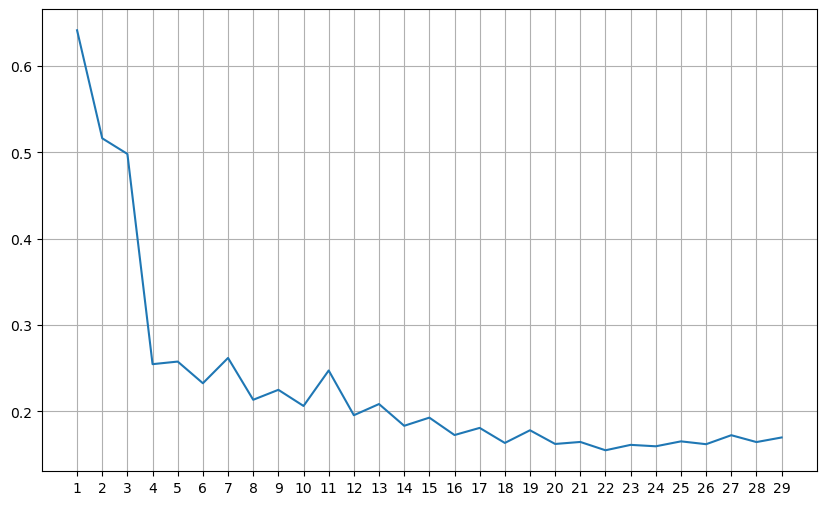

In [238]:
#parameter tuning for KNeighboursClassifier
f1 = []
for k in range(1,30):
    knn_model =KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train_encoded)
    y_predict = knn_model.predict(X_test)
    f1.append(metrics.f1_score(y_test_encoded, y_predict, average = 'macro'))

plt.figure(figsize=(10,6))
plt.plot(range(1,30),f1)
plt.xticks(range(1,30))
plt.grid()
plt.show()

In [239]:
knn_model=KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train,y_train_encoded)

print_report(knn_model)

OVERALL RESULT
              precision    recall  f1-score   support

           0       0.53      0.79      0.64        29
           1       0.75      0.56      0.64        16
           2       0.30      0.25      0.27        28
           3       0.88      0.91      0.89       376
           4       0.80      0.72      0.76       175

   micro avg       0.81      0.81      0.81       624
   macro avg       0.65      0.65      0.64       624
weighted avg       0.81      0.81      0.81       624
 samples avg       0.81      0.81      0.81       624

Accuracy:  0.8108974358974359


C:\Users\PC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


this is the end of our task. even if accuracy is not so good, but we take it, we could use for our future classifications.

### thank you